In [21]:
import pandas as pd
from trader_utils import BackTester, predictions_to_trades, get_xy
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [22]:
class DeepLearningTrader:
    def __init__(self):
        self.n = 1
        self.rolling_window = 21
        self.ticker = None
        self.scaler = None

    def fit(self, ticker, start_date, end_date): 
        self.ticker = ticker
        train_x, train_y = get_xy(ticker, start_date, end_date, self.rolling_window, self.n)
        scaler = StandardScaler()
        scaler.fit(train_x)
        self.scaler = scaler
        train_x = scaler.transform(train_x)
        model = Sequential()
        model.add(Dense(64, input_dim=3, activation='relu'))
        for i in range(4):
            model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        model.fit(train_x, train_y, epochs=500, verbose=0)
        self.model = model
    
    def generate_trades(self, start_date, end_date):
        test_x, _ = get_xy(self.ticker, start_date, end_date, self.rolling_window, self.n)
        test_x = self.scaler.transform(test_x)
        predictions = self.model.predict_classes(test_x)
        actual_start = self.rolling_window - 1
        trades = predictions_to_trades(self.ticker, predictions, start_date, end_date, self.n, actual_start)
        return trades

In [23]:
#initialize
dlt = DeepLearningTrader()

In [24]:
#define test cases

#test 1 case GOOG
in_sd = pd.datetime(2011,1,1)
in_ed = pd.datetime(2011,12,31)
out_sd = pd.datetime(2012,1,1)
out_ed = pd.datetime(2012,12,31)
ticker = 'GOOG'

# #test 2 case JPM
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'JPM'

# #test 3 case AMZN
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AMZN'

# #test 4 case AAPL
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AAPL'


In [25]:
#train model
dlt.fit(ticker, in_sd, in_ed)    

In [26]:
#intialize backtester
starting_cash = 100000
holding_limit = 1000
btr = BackTester(starting_cash, holding_limit)

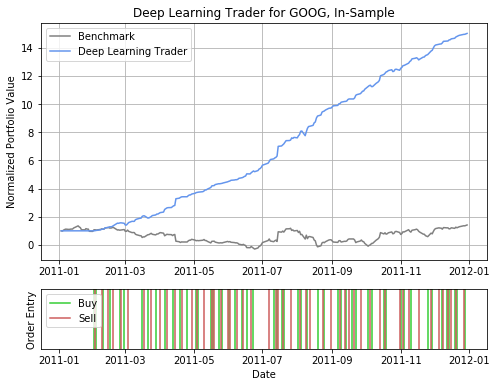

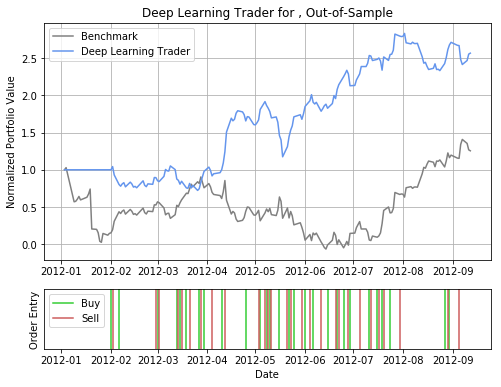

In [27]:
#generate trade in-sample
df_trades = dlt.generate_trades(in_sd, in_ed) 

plot_title = 'Deep Learning Trader for {}, In-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6))

#out-of-sample
start_date = pd.datetime(2012,1,1)
end_date = pd.datetime(2012,12,31)

#generate trade out-of-sample
df_trades = dlt.generate_trades(out_sd, out_ed) 
plot_title = 'Deep Learning Trader for , Out-of-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6)) 